In [1]:
!pip uninstall torch -y
!pip install --pre torch -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Found existing installation: torch 1.5.0
Uninstalling torch-1.5.0:
  Successfully uninstalled torch-1.5.0
Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 765.9 MB 9.2 kB/s  eta 0:00:01     |█████▊                          | 136.3 MB 58.1 MB/s eta 0:00:11MB 45.3 MB/s eta 0:00:14MB 45.3 MB/s eta 0:00:14     |██████▌                         | 156.3 MB 45.3 MB/s eta 0:00:14MB 45.3 MB/s eta 0:00:14     |███████                         | 167.5 MB 45.3 MB/s eta 0:00:14     |███████                         | 168.8 MB 45.3 MB/s eta 0:00:14     |███████                         | 169.9 MB 45.3 MB/s eta 0:00:14     |███████████████▏                | 362.8 MB 46.6 MB/s eta 0:00:09     |██████████████████████████      | 624.2 MB 51.4 MB/s eta 0:00:03     |██████████████████████████▏     | 625.1 MB 51.4 MB/s eta 0:00:03     |███████████████████████████▍    | 656.7 MB 22.2 MB/s eta 0:00:05     |███████████████████████████▋    

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST,FashionMNIST
from torchvision import transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
print(torch.__version__)

1.6.0.dev20200609+cu101


In [3]:
!git clone https://github.com/rogertrullo/VQVAE_Pytorch.git
!cp VQVAE_Pytorch/*py ./
!rm -r VQVAE_Pytorch/

from vqvae import VQVAE

Cloning into 'VQVAE_Pytorch'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
Unpacking objects: 100% (13/13), done.
remote: Total 13 (delta 4), reused 5 (delta 2), pack-reused 0


# Data

In [8]:
#mod this as needed
batch_size=64
num_workers=8
##############


transform = transforms.Compose([
        transforms.ToTensor(),
    ])
train_dataset = FashionMNIST('DATA', download=True, train=True, transform=transform)



train_loader = torch.utils.data.DataLoader(train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)


test_dataset = FashionMNIST('DATA', download=True, train=False, transform=transform)



test_loader = torch.utils.data.DataLoader(test_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

# Params

In [5]:
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 32
num_embeddings = 128
in_channels=1
nepochs=50 #number of epochs to train
lr=1e-3 #learning rate for optimizer
show_every=100

In [6]:
model_vqvae=VQVAE(num_hiddens=num_hiddens,num_embeddings=num_embeddings,embedding_dim=embedding_dim,
            num_residual_layers = num_residual_layers, num_residual_hiddens=num_residual_hiddens).cuda()#TODO add params...


In [7]:
optimizer = Adam(model_vqvae.parameters(), lr=lr, betas=(0, 0.99))
criteria=nn.CrossEntropyLoss()

for epoch in range(nepochs):
    for it,(images, labels) in enumerate(train_loader):
        images=images.cuda()
        optimizer.zero_grad() # Backward & update weights
        loss, x_hat=model_vqvae.compute_gradients(images)
        optimizer.step()
        
        if it%show_every==0:
            print(f'epoch: {epoch}, it:{it}/{len(train_loader)}, loss:{loss.item()}')

epoch: 0, it:0/938, loss:0.3331460654735565
epoch: 0, it:100/938, loss:0.046841464936733246
epoch: 0, it:200/938, loss:0.024449774995446205
epoch: 0, it:300/938, loss:0.022074755281209946
epoch: 0, it:400/938, loss:0.022053752094507217
epoch: 0, it:500/938, loss:0.020637452602386475
epoch: 0, it:600/938, loss:0.017913194373250008
epoch: 0, it:700/938, loss:0.01577049493789673
epoch: 0, it:800/938, loss:0.01718159019947052
epoch: 0, it:900/938, loss:0.0168134905397892
epoch: 1, it:0/938, loss:0.013052497990429401
epoch: 1, it:100/938, loss:0.014655216597020626
epoch: 1, it:200/938, loss:0.01137523353099823
epoch: 1, it:300/938, loss:0.014037971384823322
epoch: 1, it:400/938, loss:0.011562710627913475
epoch: 1, it:500/938, loss:0.013228625990450382
epoch: 1, it:600/938, loss:0.011797762475907803
epoch: 1, it:700/938, loss:0.01077328808605671
epoch: 1, it:800/938, loss:0.015478963032364845
epoch: 1, it:900/938, loss:0.011364303529262543
epoch: 2, it:0/938, loss:0.00910993479192257
epoch: 

KeyboardInterrupt: 

torch.Size([128, 32])


16384

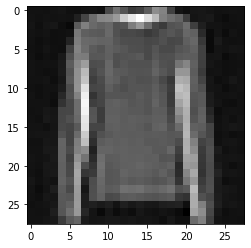

In [16]:
print(model_vqvae.codebook.shape)
shape=model_vqvae.ze.shape
indices=model_vqvae.indices
indices=indices.reshape(shape[0],shape[2], shape[3])

out=model_vqvae.compute_out_from_indices(indices)

# print(model.indices.shape)#batchx16x16
# zq=model.codebook[model.indices]
# shp=model.ze.shape
# zq=zq.reshape(shp[0],shp[2],shp[3],-1)
# zq=zq.permute(0,3,1,2)
# print(zq.shape)
# out=model.decoder(zq)
plt.imshow(out[0,0].detach().cpu(),cmap='gray')
64*16*16

Text(0.5, 1.0, 'Reconstructed from the sampled codes')

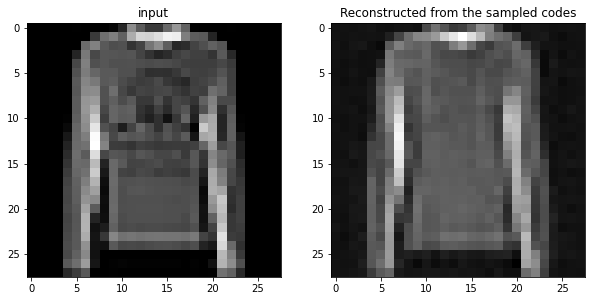

In [12]:
images,_=next(iter(test_loader))
images=images.cuda()
x_hat, _, _=model_vqvae(images)


i=0
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(images[i,0].detach().cpu(),cmap='gray')
axes[0].set_title('input')

axes[1].imshow(x_hat[i,0].detach().cpu(),cmap='gray')
axes[1].set_title('Reconstructed from the sampled codes')

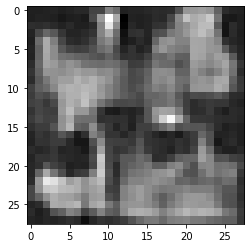

In [19]:
randind=torch.randint_like(indices,high=num_embeddings)

out=model_vqvae.compute_out_from_indices(randind)

plt.imshow(out[0,0].detach().cpu(),cmap='gray')

In [20]:
!git clone https://github.com/rogertrullo/Gated-PixelCNN-Pytorch.git
!cp Gated-PixelCNN-Pytorch/*py ./
!rm -r Gated-PixelCNN-Pytorch/

from GatedPixelCNN import PixelCNN

Cloning into 'Gated-PixelCNN-Pytorch'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 26), reused 12 (delta 5), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [21]:
nlayers=10 # number of layers for pixelcnn
inchans=1 #number of input channels (currently only one is supported)
nfeats=256 #number of feature maps across the network
Klevels=num_embeddings #number of levels to use in discretization
nepochs=5000 #number of epochs to train
lr=1e-3 #learning rate for optimizer
generate_every=300
nimgs_to_generate=16

def generate_imgs(model, shape, nimgs):
    x=torch.zeros((nimgs,1,shape[0],shape[1])).cuda()
    logits=model(x)
    model.eval()
    for i in range(x.shape[2]):
        for j in range(x.shape[3]):
            logits=model(x)
            probs=torch.softmax(logits[:,:,i,j],1)
            sample=probs.multinomial(1)
            x[:,:,i,j]=sample.float()/(Klevels-1)
    model.train()
    return x.cpu()

In [22]:
model_prior=PixelCNN(nlayers=nlayers, in_channels=inchans, nfeats=nfeats, Klevels=Klevels, ksz_A=5).cuda()

In [28]:
model_vqvae.eval()
optimizer = Adam(model_prior.parameters(), lr=lr, betas=(0, 0.99))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, threshold=1e-4)
criteria=nn.CrossEntropyLoss()


# images,_,_=next(iter(train_loader))
# images=images.cuda()
# _, _, _=model(images)
# shape=model.ze.shape
# z=model.indices
# z=z.reshape(shape[0],shape[2], shape[3]).detach()

# z_float=(z.float()/(Klevels-1)).unsqueeze(1)
# z_float.requires_grad_()

for epoch in range(nepochs):
    for it,(images, _,) in enumerate(train_loader):
        
        images=images.cuda()
        _, _, _=model_vqvae(images)
        shape=model_vqvae.ze.shape
        z=model_vqvae.indices
        z=z.reshape(shape[0],shape[2], shape[3])

        z_float=(z.float()/(Klevels-1)).unsqueeze(1)
        #z_float.requires_grad_()
        #print(z.min(), z.max())

        #imgs,imgs_quant= discretize_imgs(images, Klevels)
        #imgs=imgs.cuda()
        #imgs_"quant=imgs_quant.cuda()
        #print(z_float.shape)
        logits=model_prior(z_float.detach())
        #print(logits.shape)
        #print(z.shape)

        loss=criteria(logits,z)
        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        #print(model_prior.layers[0].hconv.weight.grad[0])
        #print(z_float.grad[0].mean())
        #print(z_float[0])
        optimizer.step()

        if it%show_every==0:
            #print(z_float.grad[0].mean())
            print(f'epoch: {epoch}, it:{it}/{len(train_loader)}, loss:{loss.item()}')
            
    scheduler.step(loss)

epoch: 0, it:0/938, loss:4.856324672698975
epoch: 0, it:100/938, loss:4.097647190093994
epoch: 0, it:200/938, loss:3.9334638118743896
epoch: 0, it:300/938, loss:3.7523956298828125
epoch: 0, it:400/938, loss:3.710120439529419
epoch: 0, it:500/938, loss:3.679757833480835
epoch: 0, it:600/938, loss:3.6030361652374268
epoch: 0, it:700/938, loss:3.532132625579834
epoch: 0, it:800/938, loss:3.493411064147949
epoch: 0, it:900/938, loss:3.2697126865386963
epoch: 1, it:0/938, loss:3.333106279373169
epoch: 1, it:100/938, loss:3.272444725036621
epoch: 1, it:200/938, loss:3.156203269958496
epoch: 1, it:300/938, loss:3.364394187927246
epoch: 1, it:400/938, loss:3.1038002967834473
epoch: 1, it:500/938, loss:3.1167447566986084
epoch: 1, it:600/938, loss:3.202674627304077
epoch: 1, it:700/938, loss:3.0217032432556152
epoch: 1, it:800/938, loss:2.93473219871521
epoch: 1, it:900/938, loss:3.1099650859832764
epoch: 2, it:0/938, loss:3.1799542903900146
epoch: 2, it:100/938, loss:2.9020473957061768
epoch: 

epoch: 17, it:800/938, loss:2.3948609828948975
epoch: 17, it:900/938, loss:2.3350651264190674
epoch: 18, it:0/938, loss:2.3016598224639893
epoch: 18, it:100/938, loss:2.2354519367218018
epoch: 18, it:200/938, loss:2.2955920696258545
epoch: 18, it:300/938, loss:2.384145975112915
epoch: 18, it:400/938, loss:2.2845664024353027
epoch: 18, it:500/938, loss:2.121623992919922
epoch: 18, it:600/938, loss:2.3835248947143555
epoch: 18, it:700/938, loss:2.2662267684936523
epoch: 18, it:800/938, loss:2.3535332679748535
epoch: 18, it:900/938, loss:2.3541314601898193
epoch: 19, it:0/938, loss:2.2339775562286377
epoch: 19, it:100/938, loss:2.273556709289551
epoch: 19, it:200/938, loss:2.355372905731201
epoch: 19, it:300/938, loss:2.1057000160217285
epoch: 19, it:400/938, loss:2.181384563446045
epoch: 19, it:500/938, loss:2.224303722381592
epoch: 19, it:600/938, loss:2.175668478012085
epoch: 19, it:700/938, loss:2.251203775405884
epoch: 19, it:800/938, loss:2.3002474308013916
epoch: 19, it:900/938, lo

epoch: 35, it:500/938, loss:1.6157342195510864
epoch: 35, it:600/938, loss:1.729142189025879
epoch: 35, it:700/938, loss:1.7513062953948975
epoch: 35, it:800/938, loss:1.6766486167907715
epoch: 35, it:900/938, loss:1.8886874914169312
epoch: 36, it:0/938, loss:1.7244505882263184
epoch: 36, it:100/938, loss:1.576414942741394
epoch: 36, it:200/938, loss:1.6116602420806885
epoch: 36, it:300/938, loss:1.790996789932251
epoch: 36, it:400/938, loss:1.6994314193725586
epoch: 36, it:500/938, loss:1.844691276550293
epoch: 36, it:600/938, loss:1.7594045400619507
epoch: 36, it:700/938, loss:1.7527945041656494
epoch: 36, it:800/938, loss:1.6841237545013428
epoch: 36, it:900/938, loss:1.6741052865982056
epoch: 37, it:0/938, loss:1.6105138063430786
epoch: 37, it:100/938, loss:1.7117077112197876
epoch: 37, it:200/938, loss:1.573431372642517
epoch: 37, it:300/938, loss:1.6989872455596924
epoch: 37, it:400/938, loss:1.640057921409607
epoch: 37, it:500/938, loss:1.7235076427459717
epoch: 37, it:600/938, 

KeyboardInterrupt: 

torch.Size([16, 1, 28, 28])


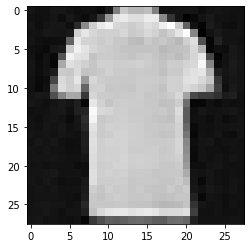

In [30]:
gens=generate_imgs(model_prior, shape=(shape[2], shape[3]), nimgs=16)
gens=(gens*(Klevels-1)).long().squeeze()
out=model_vqvae.compute_out_from_indices(gens)

plt.imshow(out[0,0].detach().cpu(),cmap='gray')
print(out.shape)

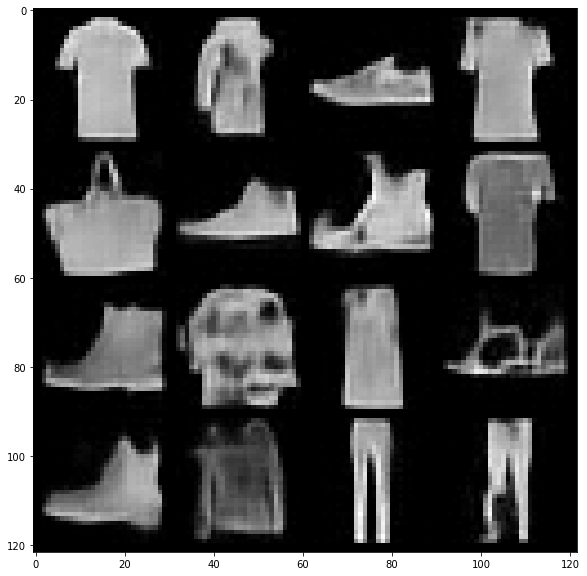

In [33]:
import numpy as np
def show(img):
    fig, ax=plt.subplots(figsize=(10,10))
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

tmp=make_grid(out.cpu().detach(), nrow=4)
show(tmp)